In [3]:
import numpy as np, pandas as pd, scipy.optimize as sopt
import matplotlib.pyplot as plt
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext rpy2.ipython

import subprocess

### 1. Nelder-mead method

#### 1.1. Implementation

In [2]:
class Observer:
    def __init__(self, eval_fun, name):
        self.name = name
        self.savefile = name + ".tex"
        self.observations = pd.DataFrame(columns=["fun", "run", "time", "iter", "score"])
        self.eval_fun = eval_fun
        self.run = 0
        
    def start_observing(self):
        self.stime = time.time()
        self.niter = 0
        self.run += 1
        
    def observe(self, citer, x):
        self.observations = self.observations.append({"fun": self.name,
                                                      "run": self.run,
                                                      "time": time.time() - self.stime,
                                                      "iter": citer,
                                                      "x": x}, ignore_index = True)
    
    def evaluate(self):
        self.observations["score"] = self.observations["x"].apply(self.eval_fun)
    
    def save_observations(self):
        self.observations.to_latex(self.savefile)

In [3]:
def nelder_mead(f, xin, observer, alpha = 1, gamma = 2, ro = 0.5, sigma = 0.5, maxiter = 100000):
    # Initialize
    success = False
    ndim = len(xin) 
    pnts = np.array([xin for i in range(ndim+1)], dtype = "float")
    pnts[:ndim, :] = np.eye(ndim)
    fvals = f(pnts.T)
    
    observer.start_observing()
    
    for i in range(maxiter):
        print(f"Iteration {i}", end="\r")
        find = np.argsort(fvals)
        pnts, fvals = pnts[find], fvals[find]
        centroid = np.mean(pnts[:ndim, :], axis = 0)
        
        # Observe current best result
        observer.observe(i, pnts[0, :])
        
        # Termination condition
        if np.std(fvals) < 1e-10:
            success = True
            break
            
        # Reflection
        xr = centroid + alpha * (centroid - pnts[-1])
        fr = f(xr)
        
        for j in range(ndim+2):
            if j > ndim or fvals[ndim - j] <= fr:
                rind = ndim - j
                break
        """
        print(f"j: {j}, rind: {rind}, ndim: {ndim}")        
        print(f"pnts:\n {pnts}")
        print(f"fvals: {fvals}")
        print(f"mu: {centroid}")
        print(f"xr: {xr}")
        print(f"fr: {fr}")
        """
        if 0 <= rind and rind < ndim:
            # print("REFLECT")
            pnts[-1, :], fvals[-1] = xr, fr
        elif rind < 0:
            # print("EXPAND")
            xe = centroid + gamma * (xr - centroid)
            fe = f(xe)
            # print(f"xe: {xe}")
            # print(fe)
            pnts[-1, :], fvals[-1] = (xe, fe) if (fe < fr) else (xr, fr)
        elif rind >= ndim:
            xc = centroid  + ro * (xr - centroid)
            fc = f(xc)
            # print(f"xc: {xc}")
            # print(fc)
            if fc < min(fr, fvals[-1]):
                # print("CONTRACT")
                pnts[-1, :], fvals[-1] = xc, fc
            else:
                # print("SHRINK")
                x0 = pnts[0, :]
                pnts = sigma * (pnts - x0) + x0
                fvals = f(pnts.T)
    
    return pnts[0], success, i

#### 1.2. Comparison

For this task it is neccesary to run HW1 to get the necessary results for comparison.

In [4]:
# TODO: use HW1

In [5]:
%run GD.py

GD
GD score: -0.19791666666666666
[-0.16666667 -0.22916667  0.16666667]
GD score: -0.19791666666666666
[-0.16666667 -0.22916667  0.16666667]
Polyak
alpha: 2.891184394090368
beta: 44.06680206056725
gamma: 0.057526829572072995
mu: 0.3506720419124005
Polyak score: -0.19791666666666669
[-0.16666667 -0.22916667  0.16666667]
alpha: 2.891184394090368
beta: 44.06680206056725
gamma: 0.057526829572072995
mu: 0.3506720419124005
Polyak score: -0.19791666666666669
[-0.16666667 -0.22916667  0.16666667]
Nesterov
Nesterov score: -0.19791666666666666
[-0.16666667 -0.22916667  0.16666667]
Nesterov score: -0.19791666666666666
[-0.16666667 -0.22916667  0.16666667]
AdaGrad
AdaGrad score: -0.19791666666666666
[-0.16666667 -0.22916667  0.16666667]
AdaGrad score: -0.18542505349391272
[-0.124088   -0.17445547  0.11202748]
Newton
Newton score: -0.19791666666666663
[-0.16666667 -0.22916667  0.16666667]
Newton score: -0.19791666666666669
[-0.16666667 -0.22916667  0.16666667]
BFGS
LBFGS score: -0.19791666666666669

In [6]:
f1 = lambda x: (x[0] - x[2])**2 + (2*x[1] + x[2])**2 + (4*x[0] - 2*x[1] + x[2])**2 + x[0] + x[1]
f2 = lambda x: (x[0] - 1)**2 + (x[1] - 1)**2 + 100*(x[1] - x[0]**2)**2 + 100*(x[2] - x[1]**2)**2
f3 = lambda x: (1.5 - x[0] + x[0]*x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + (2.625 - x[0] + x[0]*x[1]**3)**2

toy_functions = [{"fun": f1, 
                  "obs": Observer(lambda x: np.mean(np.abs(x - np.array((-1/6, -11/48, 1/6)))), "f1"),
                  "start_pnts": [np.array([0,0,0]), np.array([1,1,0])]},
                 {"fun": f2, 
                  "obs": Observer(lambda x: np.mean(np.abs(x - np.array((1,1,1)))), "f2"),
                  "start_pnts": [np.array([1.2, 1.2, 1.2]), np.array([-1, 1.2, 1.2])]},
                 {"fun": f3, "obs": Observer(lambda x: np.mean(np.abs(x - np.array((3, 0.5)))), "f3"),
                  "start_pnts": [np.array([1, 1]), np.array([4.5, 4.5])]}]

for tfun in toy_functions:
    fi, obs, spnts = tfun["fun"], tfun["obs"], tfun["start_pnts"]
    
    for spnt in spnts:
        xmin = sopt.fmin(fi, spnt)
        xint, success, uiter =  nelder_mead(fi, spnt, obs)
        obs.evaluate()
        obs.save_observations()

        print(f"Real x_min: {xmin}, f = {fi(xmin)}")
        print(f"Our x_min: {xint}, f = {fi(xint)} (converged: {success}, iterations: {uiter})")
        print(f"{'Found minimum.' if fi(xmin) >= fi(xint) else 'Failed to find minimum.'}")
        
        print("---------------------------------------------")
        print("---------------------------------------------")
        
rf = pd.concat([tfun["obs"].observations for tfun in toy_functions])
rf = rf.drop("x", axis=1)

Optimization terminated successfully.
         Current function value: -0.197917
         Iterations: 98
         Function evaluations: 180
Real x_min: [-0.16669618 -0.2291735   0.16667396], f = -0.19791665584468732
Our x_min: [-0.16666656 -0.22916415  0.16667263], f = -0.19791666650944356 (converged: True, iterations: 95)
Found minimum.
---------------------------------------------
---------------------------------------------
Optimization terminated successfully.
         Current function value: -0.197917
         Iterations: 127
         Function evaluations: 236
Real x_min: [-0.16665336 -0.22913061  0.16664039], f = -0.19791666095716387
Our x_min: [-0.16667112 -0.22917212  0.16667268], f = -0.19791666653232542 (converged: True, iterations: 99)
Found minimum.
---------------------------------------------
---------------------------------------------
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 107
         Function evaluations:

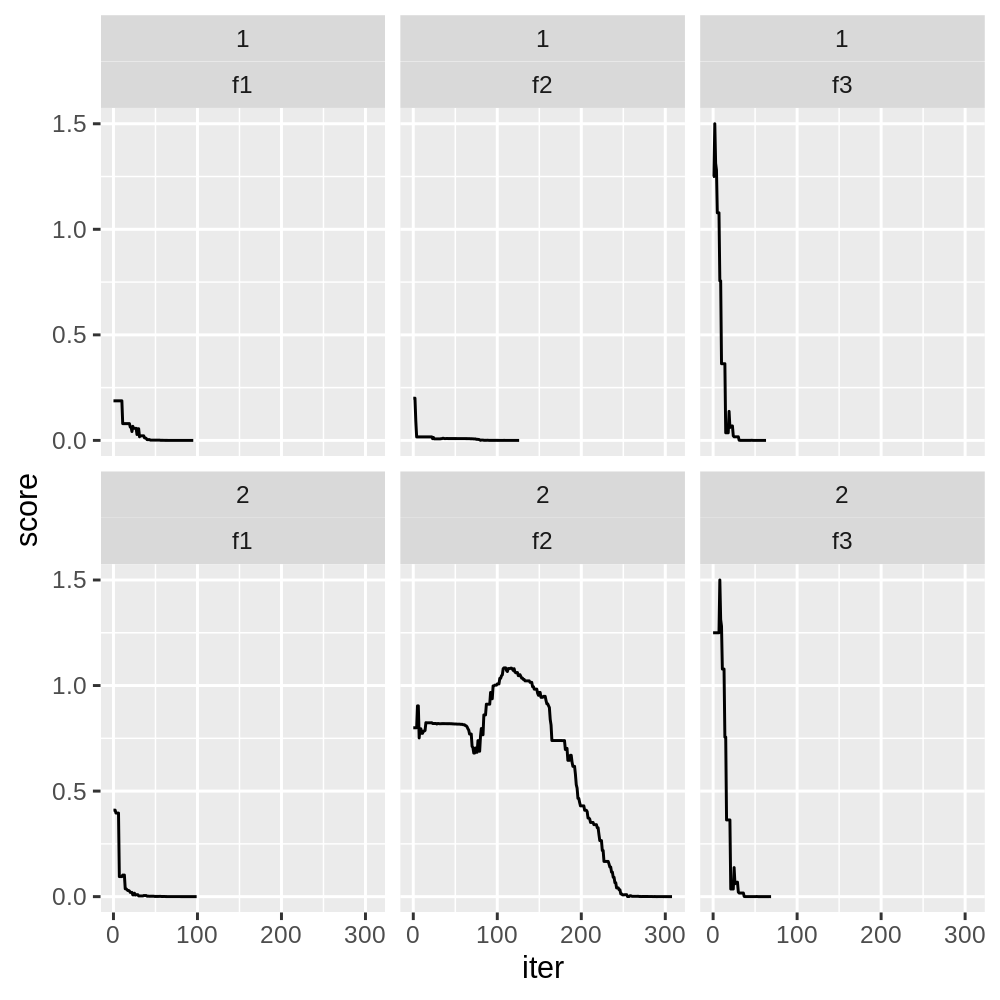

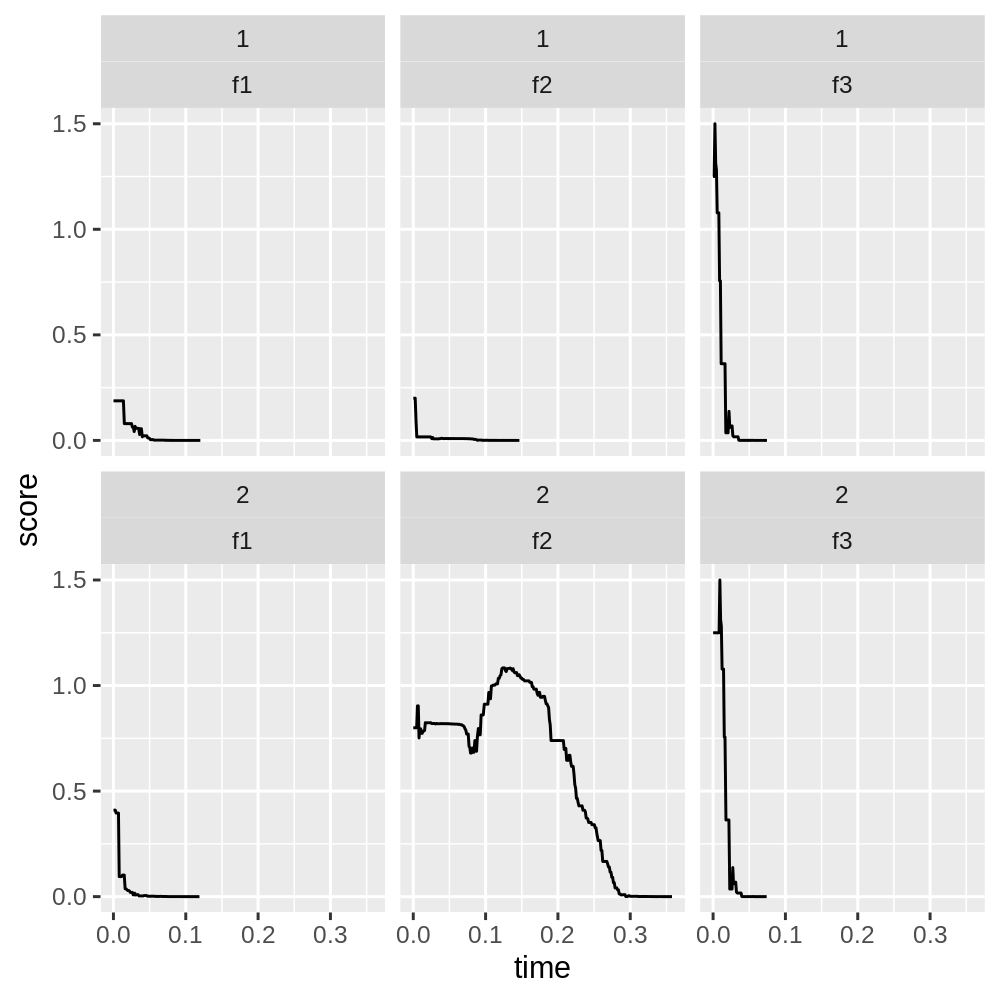

In [7]:
%%R -i rf -w 5 -h 5 --units in -r 200
library(ggplot2)
ig <- ggplot(rf, aes(x=iter, y=score)) + geom_line() + facet_wrap(~run+fun)
tg <- ggplot(rf, aes(x=time, y=score)) + geom_line() + facet_wrap(~run+fun)
print(ig)
print(tg)

### 2. Black box optimization

In [8]:
def tough_problem_1(x):
    if len(x.shape) > 1:
        out = np.array([np.longdouble(subprocess.run(["./hw4_nix", "63160248", "1", str(x[0, i]), str(x[1, i]), str(x[2, i])], capture_output=True).stdout.decode().strip()) for i in range(x.shape[1])])
    else:
        out = np.longdouble(subprocess.run(["./hw4_nix", "63160248", "1", str(x[0]), str(x[1]), str(x[2])], capture_output=True).stdout.decode().strip())
    return out
def tough_problem_2(x):
    if len(x.shape) > 1:
        out = np.array([np.longdouble(subprocess.run(["./hw4_nix", "63160248", "2", str(x[0, i]), str(x[1, i]), str(x[2, i])], capture_output=True).stdout.decode().strip()) for i in range(x.shape[1])])
    else:
        out = np.longdouble(subprocess.run(["./hw4_nix", "63160248", "2", str(x[0]), str(x[1]), str(x[2])], capture_output=True).stdout.decode().strip())
    return out
def tough_problem_3(x):
    if len(x.shape) > 1:
        out = np.array([np.longdouble(subprocess.run(["./hw4_nix", "63160248", "3", str(x[0, i]), str(x[1, i]), str(x[2, i])], capture_output=True).stdout.decode().strip()) for i in range(x.shape[1])])
    else:
        out = np.longdouble(subprocess.run(["./hw4_nix", "63160248", "3", str(x[0]), str(x[1]), str(x[2])], capture_output=True).stdout.decode().strip())
    return out

In [11]:
nrepeats = 5

toy_functions = [{"fun": tough_problem_1, 
                  "obs": Observer(tough_problem_1, "t1"),
                  "start_pnts": [np.longdouble(np.random.uniform(-5,5,3)) for i in range(nrepeats)]},
                 {"fun": tough_problem_2, 
                  "obs": Observer(tough_problem_2 "t2"),
                  "start_pnts": [np.longdouble(np.random.uniform(-5,5,3)) for i in range(nrepeats)]},
                 {"fun": tough_problem_3, "obs": Observer(tough_problem_3, "t3"),
                  "start_pnts": [np.longdouble(np.random.uniform(-5,5,3)) for i in range(nrepeats)]}]

for tfun in toy_functions:
    fi, obs, spnts = tfun["fun"], tfun["obs"], tfun["start_pnts"]
    
    for spnt in spnts:
        xint, success, uiter =  nelder_mead(fi, spnt, obs)
        obs.evaluate()
        obs.save_observations()

        print(f"Our x_min: {xint}, f = {fi(xint)} (converged: {success}, iterations: {uiter})")
        
        print("---------------------------------------------")
        print("---------------------------------------------")

rf = pd.concat([tfun["obs"].observations for tfun in toy_functions])
rf = rf.drop("x", axis=1)
mf = rf.sort_values(["iter"], ascending=False).groupby(["fun", "run"]).head(1)
mf["iter"] = mf["iter"].astype("int64")
mf = pd.concat([mf[["fun", "time", "iter", "score"]].groupby(["fun"]).mean(), mf[["fun", "time", "iter", "score"]].groupby(["fun"]).std()], axis=1)
mf = mf.round(2)
mf

Our x_min: [0.84198915 0.206102   0.61360941], f = 0.84206136021026 (converged: True, iterations: 104)
---------------------------------------------
---------------------------------------------
Our x_min: [0.84201104 0.20610162 0.61360757], f = 0.842061360181753 (converged: True, iterations: 94)
---------------------------------------------
---------------------------------------------
Our x_min: [0.8419921  0.20609597 0.61360078], f = 0.842061360079262 (converged: True, iterations: 89)
---------------------------------------------
---------------------------------------------
Our x_min: [0.8420037  0.20610235 0.61360351], f = 0.842061360031547 (converged: True, iterations: 96)
---------------------------------------------
---------------------------------------------
Our x_min: [0.84200287 0.20609939 0.61359706], f = 0.842061360017234 (converged: True, iterations: 88)
---------------------------------------------
---------------------------------------------
Our x_min: [0.61359603 0.

In [39]:
rf = pd.concat([tfun["obs"].observations for tfun in toy_functions])
rf = rf.drop("x", axis=1)
mf = rf.sort_values(["iter"], ascending=False).groupby(["fun", "run"]).head(1)
mf["iter"] = mf["iter"].astype("int64")
mf = pd.concat([mf[["fun", "time", "iter", "score"]].groupby(["fun"]).mean(), mf[["fun", "time", "iter", "score"]].groupby(["fun"]).std()], axis=1)
mf = mf.round(2)
mf

,time,iter,time,iter
fun,,,,
t1,557.78,94.2,34.94,6.42
t2,1115.17,194.0,541.21,93.80
t3,568.36,97.2,60.16,13.18


In [45]:
# TODO: add scores
tf1 = [0.84206136021026, 0.842061360181753, 0.842061360079262, 0.842061360031547, 0.842061360017234]
tf2 = [0.842061360155721, 0.842061360054445, 0.842061360047265, 0.842061360165723, 0.842061360319523]
tf3 = [0.842061360007158, 0.842061360068341, 0.842061360135263, 0.842061360424489, 0.842061360027738]

In [55]:
mf["mu_score"] = [np.mean(tf) for tf in [tf1, tf2, tf3]]
mf["sd_score"] = [np.std(tf) for tf in [tf1, tf2, tf3]]
mf.to_latex("nedler_mead_task2.tex")
mf

,time,iter,time,iter,mu_score,sd_score
fun,,,,,,
t1,557.78,94.2,34.94,6.42,0.842061,7.839193e-11
t2,1115.17,194.0,541.21,93.80,0.842061,9.868383e-11
t3,568.36,97.2,60.16,13.18,0.842061,1.523596e-10


*Step beyond*: To use gradient-descent methods we would need to aproximate the gradient using finite differences. The best suited GD method is BFGS(L-BFGS) with multiple starting points. 

### 3. Local search study

Answers to Questions #3

* Maximal matching - is a matching M where we are unable to add a vertex *v* from V(G) such that M is still a matching.
* Perfect matching - maximal matching M such that all vertices V(G) are elements of M. Near-Perfect matching - For graphs G with an odd number of vertices. Maximal matching M such that all except for exactly one vertex are elements of M.
* Greedy algorithm - pick edge e = (v_i, v_j); remove edged from G with vertices v_i or v_j; repeat until E(G) is empty. This algorithm will give maximal, not neccesary maximum matching.
* Not all graph have near-perfect or perfect matching. - Counterexample: Beam of points.


Answer to Question #4

Yes, a set with a single edge is a valid matching, therefore we can express any set as a weighed combination of elementary matchings.

#### 3.5 RelaxMaximalWeightMatching

In [402]:
# get constraint vectors - use sparse metrices (max. for 1 in array of 400)
def contains(e, v):
    return all(e[0] == v) or all(e[1] == v)

def grid_graph(lbnd=1, ubnd=2, size=20, rseed=17):
    # Get list of vertices
    V = [[(i,j) for j in range(0, size)] for i in range(0, size)]
    V = np.concatenate(V)

    # define adjecency functions
    adjecent = lambda vi, vj: np.sum(np.abs(vi - vj)) == 1

    # get list of valid edges
    E = []
    for i in range(len(V)):
        for j in range(i, len(V)):
            if adjecent(V[i], V[j]):
                E.append([V[i], V[j]])

    # generate fixed weights  
    np.random.seed(rseed)
    W = np.random.uniform(low = lbnd, high = ubnd, size = len(E))
    
    constraints = []

    for v in V:
        constraints.append([1 if contains(E[i], v) else 0 for i in range(len(E))])
        
    return V, E, W, constraints

def plot_grid(W, E):
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6), dpi=80)
    for i in range(len(W)):
        wi, ei = W[i], E[i]
        plt.plot([ei[0][0], ei[1][0]], [ei[0][1], ei[1][1]], "-", color="black", linewidth=wi)
    plt.plot(V[:, 0], V[:, 1], "o")
    
def plot_grid_solution(W, E, X_opt, name):
    plt.style.use('ggplot')
    plt.xticks(np.arange(0, 20+2, 2.0))
    plt.yticks(np.arange(0, 20+2, 2.0))
    for i in range(len(W)):
        wi, xi, ei = W[i], X_opt[i], E[i]
        plt.plot([ei[0][0], ei[1][0]], [ei[0][1], ei[1][1]], "-", color="black", linewidth=wi*xi)
        plt.scatter(V[:, 0], V[:, 1])
    plt.savefig(name, bbox_inches = "tight", dpi = 50)

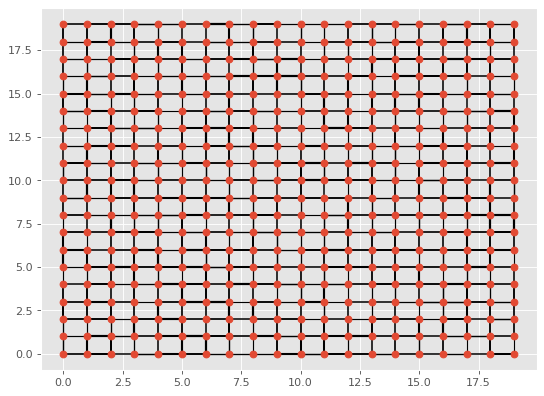

In [403]:
V, E, W, constraints = grid_graph(rseed=17)
plot_grid(W, E)

relaxMaximalWeightMatching: 338.48
non-zero edge weights: 0.26


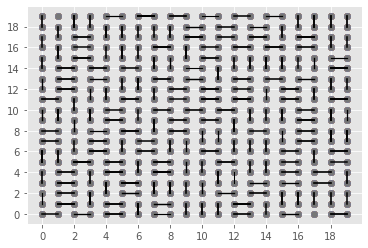

In [410]:
obj = -W
lhs_ineq = constraints
rhs_ineq = len(V) * [1]
bnd = len(W) * [(0, 1)]

res = sopt.linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="interior-point")
X_opt = res.x 
plot_grid_solution(W, E, X_opt, name = "lp_grid.png")

print(f"relaxMaximalWeightMatching: {round(-res.fun, 2)}")
print(f"non-zero edge weights: {round(sum(X_opt > 1e-6) / len(E), 2)}")

In [365]:
def local_search(V, E, W, constraints, nrepl = 3, maxiter = 5000, maxtol = 30, rmax = 0.67, frem = 0.1):
    """
    TODO: write description
    """
    W_mu, W_sd = np.mean(W), 2 * np.std(W)
    C = np.array(constraints)
    BM = np.array(len(W) * [0]) # start with empty set
    M = np.array(len(W) * [0]) # start with empty set
    inds = np.arange(len(W))
    
    W_add, P_add = W, W / sum(W)
    W_rem, P_rem = (1/W), (1/W) / sum(1/W)
    
    bestScore = 0
    ntol = 0
    
    for i in range(maxiter):
        # remove
        nremoved = 0
        while nremoved < nrepl:
            rinds = np.random.choice(inds, size = 1, p = P_rem)
            if W[rinds] == 0: continue
            remove_smaller = np.random.normal(W_mu, W_sd, size = 1)
            if W[rinds] > remove_smaller: continue
            M[rinds] = 0
            nremoved += 1

        # add - checks needed to make sure matching valid
        nadded = 0
        while nadded < nrepl:
            ainds = np.random.choice(inds, size = 1, p = P_add)
            if W[ainds] == 1: continue
            add_greater = np.random.normal(W_mu, W_sd, size = 1)
            if W[ainds] < add_greater: continue
            M[ainds] = 1
            if not all(C.dot(M) <= 1):
                M[ainds] = 0
                continue
            nadded += 1

        # add only if it improves score
        currScore = W.dot(M)
        if currScore > bestScore:
            bestScore = currScore
            BM = np.copy(M)
            ntol = 0
        else:
            M = np.copy(BM)
            ntol += 1

        # jump if plateau
        if ntol == maxtol:
            nremoved = 0
            while nremoved < round(frem * sum(BM)):
                rinds = np.random.choice(inds, size = 1, p = P_rem)
                if W[rinds] == 0: continue
                remove_smaller = np.random.normal(W_mu, W_sd, size = 1)
                if W[rinds] > remove_smaller: continue
                BM[rinds] = 0
                nremoved += 1
            ntol = round(maxtol * rmax)
            bestScore = W.dot(BM)
            # randomly remove points
            
    return BM

In [366]:
rdf = pd.DataFrame(columns=["adj", "mu", "std"])

nreap = 10

# run for different adjecencies - 1,2,3,4,5
for i in range(1, 6):
    BMs = [local_search(V, E, W, constraints, nrepl=i) for _ in range(nreap)] # quantify uncertainty
    scores = [W.dot(BM) for BM in BMs]
    rdf = rdf.append({
        "adj": i,
        "mu": np.mean(scores),
        "std": np.std(scores)
    }, ignore_index=True)
    print(f"{i}-adjecency: mu={np.mean(scores)}, std={np.std(scores)}")
rdf

1-adjecency: mu=290.9947150920044, std=3.4992222311287824
2-adjecency: mu=296.57504868012745, std=4.6474809618591255
3-adjecency: mu=301.14617961576147, std=4.877527726176059
4-adjecency: mu=302.52010168172603, std=3.6107406388940393
5-adjecency: mu=304.27910511618205, std=4.380734789904166


,adj,mu,std
0,1.0,290.994715,3.499222
1,2.0,296.575049,4.647481
2,3.0,301.146180,4.877528
3,4.0,302.520102,3.610741
4,5.0,304.279105,4.380735


In [364]:
rdf

,adj,mu,std
0,1.0,292.113724,5.237771
1,2.0,293.000924,5.157790
2,3.0,300.313961,5.153927
3,4.0,301.491334,3.298644
4,5.0,302.402668,2.730955


In [ ]:
plot_grid_solution(W, E, BM)
print(f"Local search score: {W.dot(BM)}")